In [1]:
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# rcParams['font.family'] = 'monospace'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['savefig.dpi'] = 300

import matplotlib.font_manager
#[f.name for f in matplotlib.font_manager.fontManager.ttflist]

In [92]:
colors = sns.color_palette('Paired')
colors[0]

(0.6509803921568628, 0.807843137254902, 0.8901960784313725)

In [2]:
with open(r'../results/results.pickle', 'rb') as result_file:
    results = pickle.load(result_file)

In [106]:
# covert from dict to DF
r = pd.DataFrame.from_dict(results)
# only handle the BPIC datasets
r = r.loc[r.dataset.str.contains('BPIC')]

In [107]:
# Output dataset information for papers
datasets = {}
dataset_names = [re.match('../datasets/(.+).csv', x).groups()[0] for x in list(sorted(set(r['dataset'])))]
# datasets['Dataset'] = [re.sub('_', ' ', x) for x in dataset_names]
datasets['dataset'] = dataset_names

datasets['Number of Columns'] = [len(pd.read_csv(x, nrows=1).columns) for x in list(sorted(set(r['dataset'])))]
r['dataset'] = r['dataset'].apply(lambda x: re.match('../datasets/(.+).csv', x).groups()[0])

print(pd.DataFrame.from_dict(datasets).to_latex(index=False))

\begin{tabular}{lr}
\toprule
                                    dataset &  Number of Columns \\
\midrule
           BPIC2011\_Dutch\_academic\_hospital &                128 \\
          BPIC2012\_loan\_application\_process &                  7 \\
               BPIC2013\_incident\_management &                 12 \\
BPIC2013\_problem\_management\_closed\_problems &                 12 \\
  BPIC2013\_problem\_management\_open\_problems &                 11 \\
                                 BPIC2015\_1 &                 29 \\
                                 BPIC2015\_2 &                 28 \\
                                 BPIC2015\_3 &                 29 \\
                                 BPIC2015\_4 &                 29 \\
                                 BPIC2015\_5 &                 29 \\
                                   BPIC2017 &                 19 \\
                                   BPIC2018 &                 75 \\
   BPIC2019\_purchase\_order\_handling\_process &        

/tmp/ipykernel_1220/632180442.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame.from_dict(datasets).to_latex(index=False))


In [108]:
r.groupby('dataset').count()

,time_cand_selection,time_score_eval,n_timestamp_cand,n_case_id_cand,n_activity_cand,n_top_cands,n_cands,scores,correct_indices,cands,miner,metric,n_RF_estimators
dataset,,,,,,,,,,,,,
BPIC2011_Dutch_academic_hospital,137,137,137,137,137,137,137,137,137,137,130,130,130
BPIC2012_loan_application_process,110,110,110,110,110,110,110,110,110,110,100,100,100
BPIC2013_incident_management,110,110,110,110,110,110,110,110,110,110,100,100,100
BPIC2013_problem_management_closed_problems,110,110,110,110,110,110,110,110,110,110,100,100,100
BPIC2013_problem_management_open_problems,110,110,110,110,110,110,110,110,110,110,100,100,100
BPIC2015_1,191,191,191,191,191,191,191,191,191,191,190,190,190
BPIC2015_2,173,173,173,173,173,173,173,173,173,173,170,170,170
BPIC2015_3,146,146,146,146,146,146,146,146,146,146,140,140,140
BPIC2015_4,191,191,191,191,191,191,191,191,191,191,190,190,190


In [109]:
# check if the correct tuple is included in the candidates
r['is_in'] = r[['correct_indices', 'cands']].apply(lambda x: x['correct_indices'] in x['cands'], axis=1)

In [110]:
# check if the candidate with the highest score is the correct one
def if_highest_cands_is_correct(x):
    if x['n_cands'] == 0:
        # this means that no candidate is identified. return a dummy tuple
        return [[-1, -1, -1]]
    elif x['n_cands'] == 1:
        # this means that we only have a single candidate at the first stage
        return [np.array(x['cands']).flatten().tolist()]
    else:
        return [x['cands'][i] for i in np.argwhere(np.amax(x['scores']) == x['scores']).flatten().tolist()]
    
r['identified_indices'] = r.apply(lambda x: if_highest_cands_is_correct(x), axis=1)

In [111]:
# find identification accuracy by each key column
r['case_id_precision'] = r.apply(lambda x: sum([i[0] == x['correct_indices'][0] for i in x['identified_indices']]) / len(x['identified_indices']), axis=1)
r['timestamp_precision'] = r.apply(lambda x: sum([i[1] == x['correct_indices'][1] for i in x['identified_indices']]) / len(x['identified_indices']), axis=1)
r['activity_precision'] = r.apply(lambda x: sum([i[2] == x['correct_indices'][2] for i in x['identified_indices']]) / len(x['identified_indices']), axis=1)

In [112]:
# check if all columns are correctly identified
r['is_all_correct'] = r.apply(lambda x: x['correct_indices'] in x['identified_indices'], axis=1)

In [113]:
# find how much we could identify all the key columns correctly
# conditions:
r.groupby(['dataset', 'n_top_cands']).apply(lambda x: round(sum(x['is_all_correct']) / len(x), ndigits=2))

dataset                                      n_top_cands
BPIC2011_Dutch_academic_hospital             1              0.00
                                             2              0.00
BPIC2012_loan_application_process            1              0.60
                                             2              0.56
BPIC2013_incident_management                 1              0.50
                                             2              0.57
BPIC2013_problem_management_closed_problems  1              0.30
                                             2              0.78
BPIC2013_problem_management_open_problems    1              0.90
                                             2              0.83
BPIC2015_1                                   1              0.00
                                             2              0.00
BPIC2015_2                                   1              0.73
                                             2              0.45
BPIC2015_3                       

In [114]:
tmp = pd.merge(
    r.groupby(['dataset']).apply(lambda x: round(sum(x['case_id_precision']) / len(x), ndigits=2)).reset_index(name='case_id'),
    r.groupby(['dataset']).apply(lambda x: round(sum(x['activity_precision']) / len(x), ndigits=2)).reset_index(name='activity'), 
    on='dataset')
pd.merge(
    tmp,
    r.groupby(['dataset']).apply(lambda x: round(sum(x['timestamp_precision']) / len(x), ndigits=2)).reset_index(name='timestamp'),
    on='dataset')

,dataset,case_id,activity,timestamp
0,BPIC2011_Dutch_academic_hospital,0.00,0.01,0.61
1,BPIC2012_loan_application_process,0.65,0.99,0.87
2,BPIC2013_incident_management,0.67,0.78,0.91
3,BPIC2013_problem_management_closed_problems,0.84,0.85,1.00
4,BPIC2013_problem_management_open_problems,0.87,0.92,1.00
5,BPIC2015_1,0.99,0.51,0.00
6,BPIC2015_2,0.71,0.36,0.74
7,BPIC2015_3,0.70,0.12,0.65
8,BPIC2015_4,0.90,0.43,0.10
9,BPIC2015_5,0.71,0.48,0.08


,n_top_cands,metric,time
0,1,Buijs2014,19.24
1,1,fitness,8.81
2,1,generalization,8.86
3,1,precision,15.76
4,1,simplicity,7.24
5,2,Buijs2014,55.40
6,2,fitness,19.37
7,2,generalization,21.60
8,2,precision,43.72
9,2,simplicity,14.64


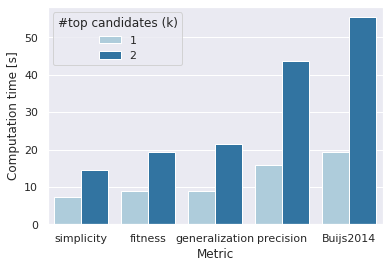

In [115]:
r_time = r.groupby(['n_top_cands', 'metric'])\
    .apply(lambda x: round(np.mean(x['time_cand_selection'] + x['time_score_eval']), ndigits=2))\
    .to_frame('time')\
    .reset_index()
display(r_time)

plt.figure(figsize=(6, 4))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.barplot(data=r_time, hue='n_top_cands', y='time', x='metric',
            order=['simplicity', 'fitness', 'generalization', 'precision', 'Buijs2014'],
            palette=sns.color_palette('Paired'))
plt.legend(title='#top candidates (k)')
plt.xlabel('Metric')
plt.ylabel('Computation time [s]')
plt.savefig('../plots/computation_time.pdf', bbox_inches='tight')

In [117]:
def precision_summary(x):
    c = round(sum(x['case_id_precision']) / len(x), ndigits=2)
    t = round(sum(x['timestamp_precision']) / len(x), ndigits=2)
    a = round(sum(x['activity_precision']) / len(x), ndigits=2)
    avg = round(np.mean([c, t, a]), ndigits=2)
    return pd.DataFrame({'accuracy': [c, t, a, avg]}, 
                        index=['case-id', 'timestamp', 'activity', 'average'])
    # return pd.DataFrame(data={'case_id': [c], 'timestamp': [t], 'activity': [a], 'average': [avg]})

,metric,n_top_cands,level_2,accuracy
0,Buijs2014,1,case-id,0.74
1,Buijs2014,1,timestamp,0.45
2,Buijs2014,1,activity,0.39
3,Buijs2014,1,average,0.53
4,Buijs2014,2,case-id,0.51
5,Buijs2014,2,timestamp,0.67
6,Buijs2014,2,activity,0.43
7,Buijs2014,2,average,0.54
8,fitness,1,case-id,0.74
9,fitness,1,timestamp,0.45


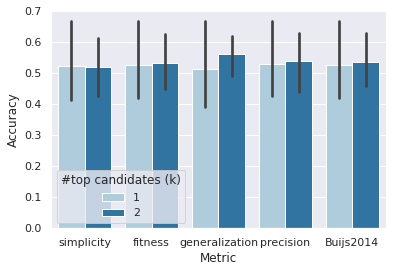

In [118]:
# metric (accuracy and time)
pd.set_option('display.max_rows', None)

# tmp = r.loc[(r['miner'] == 'inductive_miner') & (len(r['scores']) > 0)]\
tmp = r.groupby(['metric', 'n_top_cands'])\
.apply(func=precision_summary)\
.reset_index()
display(tmp)

plt.figure(figsize=(6, 4))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.barplot(data=tmp, x='metric', y='accuracy', hue='n_top_cands',
            order=['simplicity', 'fitness', 'generalization', 'precision', 'Buijs2014'],
            palette=sns.color_palette('Paired'))
plt.legend(title='#top candidates (k)')
plt.xlabel('Metric')
plt.ylabel('Accuracy')
plt.savefig('../plots/accuracy_metric.pdf', bbox_inches='tight')

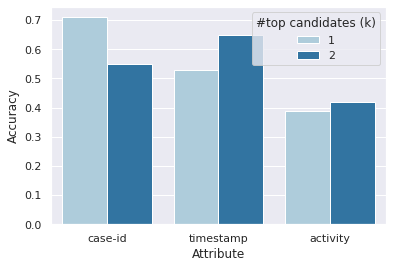

In [120]:
tmp = r.groupby(['n_top_cands'])\
    .apply(precision_summary)\
    .reset_index()

plt.figure(figsize=(6, 4))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.barplot(data=tmp, x='level_1', y='accuracy', hue='n_top_cands',
            order=['case-id', 'timestamp', 'activity'],
            palette=sns.color_palette('Paired'))
plt.legend(title='#top candidates (k)')
plt.xlabel('Attribute')
plt.ylabel('Accuracy')
plt.savefig('../plots/accuracy_by_attribute.pdf', bbox_inches='tight')

,miner,level_1,accuracy
0,heuristics_miner,case-id,0.57
1,heuristics_miner,timestamp,0.62
2,heuristics_miner,activity,0.40
3,heuristics_miner,average,0.53
4,inductive_miner,case-id,0.62
5,inductive_miner,timestamp,0.58
6,inductive_miner,activity,0.42
7,inductive_miner,average,0.54


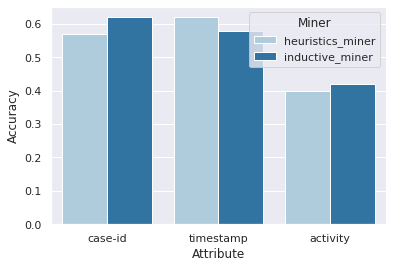

In [121]:
# metric (accuracy and miner)
# conditions: 
pd.set_option('display.max_rows', None)

tmp = r.groupby(['miner'])\
.apply(func=precision_summary)\
.reset_index()
display(tmp)

plt.figure(figsize=(6, 4))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.barplot(data=tmp, x='level_1', y='accuracy', hue='miner',
            order=['case-id', 'timestamp', 'activity'],
            palette=sns.color_palette('Paired'))
plt.legend(title='Miner')
plt.xlabel('Attribute')
plt.ylabel('Accuracy')
plt.savefig('../plots/accuracy_miner.pdf', bbox_inches='tight')

In [127]:
# miner (accuracy and time?)
tmp = r[['dataset', 'miner', 'n_top_cands', 'case_id_precision', 'activity_precision', 'timestamp_precision']]
# replace miner == None with 'NA' when no miner was used (i.e., only identified at stage 1)
tmp.fillna('NA', inplace=True)
tmp.groupby(['dataset', 'miner', 'n_top_cands']) \
.apply(lambda x: round(np.mean(x), ndigits=2))

/tmp/ipykernel_1220/4253856388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.fillna('NA', inplace=True)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  return mean(axis=axis, dtype=

n_top_cands  \
dataset                                     miner            n_top_cands                
BPIC2011_Dutch_academic_hospital            NA               1                    1.0   
                                            heuristics_miner 1                    1.0   
                                                             2                    2.0   
                                            inductive_miner  1                    1.0   
                                                             2                    2.0   
BPIC2012_loan_application_process           NA               1                    1.0   
                                            heuristics_miner 2                    2.0   
                                            inductive_miner  2                    2.0   
BPIC2013_incident_management                NA               1                    1.0   
                                            heuristics_miner 2                    2.0   
                                            inductive_miner  2                    2.0   
BPIC2013_problem_management_closed_problems NA               1                    1.0   
                                            heuristics_miner 2                    2.0   
                                            inductive_miner  2                    2.0   
BPIC2013_problem_management_open_problems   NA               1                    1.0   
                                            heuristics_miner 2                    2.0   
                                            inductive_miner  2                    2.0   
BPIC2015_1                                  NA               1                    1.0   
                                            heuristics_miner 1                    1.0   
                                                             2                    2.0   
                                            inductive_miner  1                    1.0   
                                                             2                    2.0   
BPIC2015_2                                  NA               1                    1.0   
                                            heuristics_miner 1                    1.0   
                                                             2                    2.0   
                                            inductive_miner  1                    1.0   
                                                             2                    2.0   
BPIC2015_3                                  NA               1                    1.0   
                                            heuristics_miner 1                    1.0   
                                                             2                    2.0   
                                            inductive_miner  1                    1.0   
                                                             2                    2.0   
BPIC2015_4                                  NA               1                    1.0   
                                            heuristics_miner 1                    1.0   
                                                             2                    2.0   
                                            inductive_miner  1                    1.0   
                                                             2                    2.0   
BPIC2015_5                                  heuristics_miner 1                    1.0   
                                                             2                    2.0   
                                            inductive_miner  1                    1.0   
                                                             2                    2.0   
BPIC2017                                    NA               1                    1.0   
                                            heuristics_miner 2                    2.0   
                                            inductive_miner  2       

,dataset,level_1,accuracy,Number of Columns
0,BPIC2011_Dutch_academic_hospital,average,0.21,128
1,BPIC2012_loan_application_process,average,0.84,7
2,BPIC2013_incident_management,average,0.79,12
3,BPIC2013_problem_management_closed_problems,average,0.90,12
4,BPIC2013_problem_management_open_problems,average,0.93,11
5,BPIC2015_1,average,0.50,29
6,BPIC2015_2,average,0.60,28
7,BPIC2015_3,average,0.49,29
8,BPIC2015_4,average,0.48,29
9,BPIC2015_5,average,0.42,29


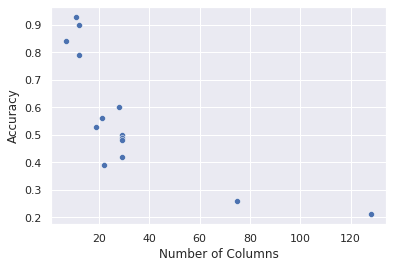

In [123]:
# accuracy vs number of columns 
tmp = r.groupby(['dataset'])\
.apply(func=precision_summary)\
.reset_index()
tmp = tmp.loc[tmp['level_1'] == 'average']
tmp2 = pd.DataFrame.from_dict(datasets)

r_acc_n_col = pd.merge(tmp, tmp2, on='dataset', how='outer')
display(r_acc_n_col)

plt.figure(figsize=(6, 4))
sns.set_style('darkgrid')
sns.set(font_scale=1)
sns.scatterplot(data=r_acc_n_col, x='Number of Columns', y='accuracy')
plt.ylabel('Accuracy')
plt.savefig('../plots/accuracy_n_columns.pdf', bbox_inches='tight')

In [124]:
tmp = r.groupby(['n_top_cands', 'miner'])\
    .apply(lambda x: round(np.mean(x['time_cand_selection']), ndigits=2))\
    .to_frame('time')\
    .reset_index()
display(tmp)

tmp = r.groupby(['n_top_cands', 'miner'])\
    .apply(lambda x: round(np.mean(x['time_score_eval']), ndigits=2))\
    .to_frame('time')\
    .reset_index()
display(tmp)

,n_top_cands,miner,time
0,1,heuristics_miner,0.58
1,1,inductive_miner,0.58
2,2,heuristics_miner,0.60
3,2,inductive_miner,0.60


,n_top_cands,miner,time
0,1,heuristics_miner,5.65
1,1,inductive_miner,17.15
2,2,heuristics_miner,17.01
3,2,inductive_miner,43.68
